In [1]:

import warnings
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv("data/data_deals.csv")
    df.drop(columns=['_id'])
    print(df.columns)
    print(df.shape)
except Exception:
    print("Seems we have a problem")


Index(['_id', 'sale_day', 'address', 'property_type', 'rooms_number', 'floor',
       'build_year', 'building_mr', 'sold_part', 'full_price', 'city'],
      dtype='object')
(517569, 11)


In [3]:
# sale_day "05-06-2016"
# build_year "2017"
df['sale_day'] = pd.to_datetime(df['sale_day'], format="%d-%m-%Y")
df['build_year'] = pd.to_datetime(df['build_year'], format="%Y")
print(df.head(1))


                        _id   sale_day        address    property_type  \
0  5cab7d497e16a98c7a79bd4a 2018-12-25  יונה הנביא 36  דירה בבית קומות   

   rooms_number floor build_year  building_mr sold_part   full_price  \
0           5.0  קרקע 2017-01-01          126       NaN  5,470,085 ₪   

          city  
0  תל אביב יפו  


In [4]:
# remove properties that their date is before 2015
from_year = 2015
df = df.loc[(df['sale_day'].dt.year >= from_year)]
df.shape

(174967, 11)

In [5]:
# List unique values in the df['name'] column
cols = ['full_price', 'sold_part', 'floor']
for col in cols:
    try:
        df.replace({col: {'₪': '',
                          '\$': '',
                          'קרקע': 0,
                          'לא צוין מחיר': None,
                          'לא צוין': None,
                          ',': '',
                          '%': '',
                          ' ': ''}}, regex=True, inplace=True)
    except TypeError:
        # in case of double replacement
        pass
df.shape

(174967, 11)

In [6]:
# Getting Description
df = df[pd.notnull(df['floor'])]
df['floor'] = df['floor'].astype(int)
df['full_price'] = df['full_price'].astype(int)
df['full_price'].describe()

count    1.749670e+05
mean     1.411957e+06
std      1.117611e+06
min      2.000000e+00
25%      7.650000e+05
50%      1.250000e+06
75%      1.775000e+06
max      1.322710e+08
Name: full_price, dtype: float64

In [7]:
# df['street'] = df['address'].astype(float)
split_data = df['address'].str.rsplit(n=1,expand=True)
print(split_data.head(5))
df['street_name'] = split_data[0]
df['street_number'] = split_data[1]
df['street_number'].head(5)

            0   1
0  יונה הנביא  36
1  יונה הנביא  25
2  יונה הנביא  26
3  יונה הנביא  24
4  יונה הנביא  26


0    36
1    25
2    26
3    24
4    26
Name: street_number, dtype: object

In [8]:
# format sold_part to full_price
df['sold_part'] = df['sold_part'].astype(float)
df['sold_part'].fillna(100, inplace = True)
df['final_price'] = (100 / df['sold_part']) * df['full_price']
df['final_price'] = df['final_price'].astype(int)
df.drop(columns=['sold_part', 'full_price'])
print(df.head(5))


                        _id   sale_day        address    property_type  \
0  5cab7d497e16a98c7a79bd4a 2018-12-25  יונה הנביא 36  דירה בבית קומות   
1  5cab7d497e16a98c7a79bd4b 2018-12-07  יונה הנביא 25  דירה בבית קומות   
2  5cab7d497e16a98c7a79bd4c 2018-05-10  יונה הנביא 26  דירה בבית קומות   
3  5cab7d497e16a98c7a79bd4d 2018-01-24  יונה הנביא 24  דירה בבית קומות   
4  5cab7d497e16a98c7a79bd4e 2017-09-13  יונה הנביא 26  דירה בבית קומות   

   rooms_number  floor build_year  building_mr  sold_part  full_price  \
0           5.0      0 2017-01-01          126      100.0     5470085   
1           3.0      1 2018-01-01           78       10.0      410000   
2           3.0      0 1950-01-01           58      100.0     2900000   
3           1.0      1 1960-01-01           23       43.7      481250   
4           2.5      1 1930-01-01           58      100.0     2500000   

          city street_name street_number  final_price  
0  תל אביב יפו  יונה הנביא            36      5470085  
1  ת

In [9]:
# remove properties that their price is too low or too high
min_price = 100000
max_price = 5000000

In [10]:
# remove properties that their price is too low or too high
df = df.loc[(min_price < df['final_price']) & (df['final_price'] < max_price)]
df.shape

(172080, 14)

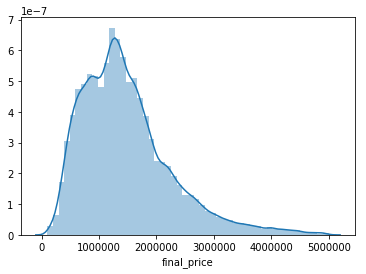

In [11]:
sns.distplot(df['final_price'])

In [12]:
df.to_csv('data/data_deals_done.csv', encoding='utf-8', index=False)

In [13]:
try:
    df = pd.read_csv("data/data_deals_done.csv")
    print(df.columns)
    print(df.shape)
except Exception:
    print("Seems we have a problem")


Index(['_id', 'sale_day', 'address', 'property_type', 'rooms_number', 'floor',
       'build_year', 'building_mr', 'sold_part', 'full_price', 'city',
       'street_name', 'street_number', 'final_price'],
      dtype='object')
(172080, 14)


In [14]:
used_features = ['sale_day', 'street_name', 'street_number', 'property_type', 'rooms_number', 'floor',
       'build_year_class', 'building_mr', 'city']

#df['sale_day'] = df['sale_day'].map(dt.datetime.toordinal)
year_classes = {
    'A': range(2016,2030), 
    'B': range(2009,2016),
    'C': range(1,2009)
}

def year_norm(_year):
    for _class, _range in year_classes.items():
        if int(_year.year) in _range:
            return _class
    return 'C'

df['build_year'] = pd.to_datetime(df['build_year'], format="%Y-%m-%d")
df['build_year_class'] = df['build_year'].map(year_norm)
print(df['build_year_class'].describe())

count     172080
unique         3
top            C
freq      121122
Name: build_year_class, dtype: object


In [15]:
X = df[used_features]
y = df['final_price']

In [16]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
# integer encode
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
# integer_encoded = df.apply(le.fit_transform)

# apply the values into the original data
for row in X[used_features]:
    X[row] = le.fit_transform(df[row])


In [17]:
cat = len(X.select_dtypes(include=['object']).columns)
num = len(X.select_dtypes(include=['int64','float64', 'datetime']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

df.isna().any()

Total Features:  0 categorical + 9 numerical = 9 features


_id                 False
sale_day            False
address             False
property_type       False
rooms_number        False
floor               False
build_year          False
building_mr         False
sold_part           False
full_price          False
city                False
street_name         False
street_number       False
final_price         False
build_year_class    False
dtype: bool

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [19]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
print(lm.intercept_)

244084.65993823344


In [21]:
print(X.columns)
print(lm.coef_)

Index(['sale_day', 'street_name', 'street_number', 'property_type',
       'rooms_number', 'floor', 'build_year_class', 'building_mr', 'city'],
      dtype='object')
[ 9.55763396e+01 -2.39707881e+01  5.12563324e+01  4.97907126e+04
  4.60154871e+04  3.17785195e+04 -1.13210947e+05  7.79869739e+03
  3.24159795e+03]


In [22]:
predictions = lm.predict(X_test)

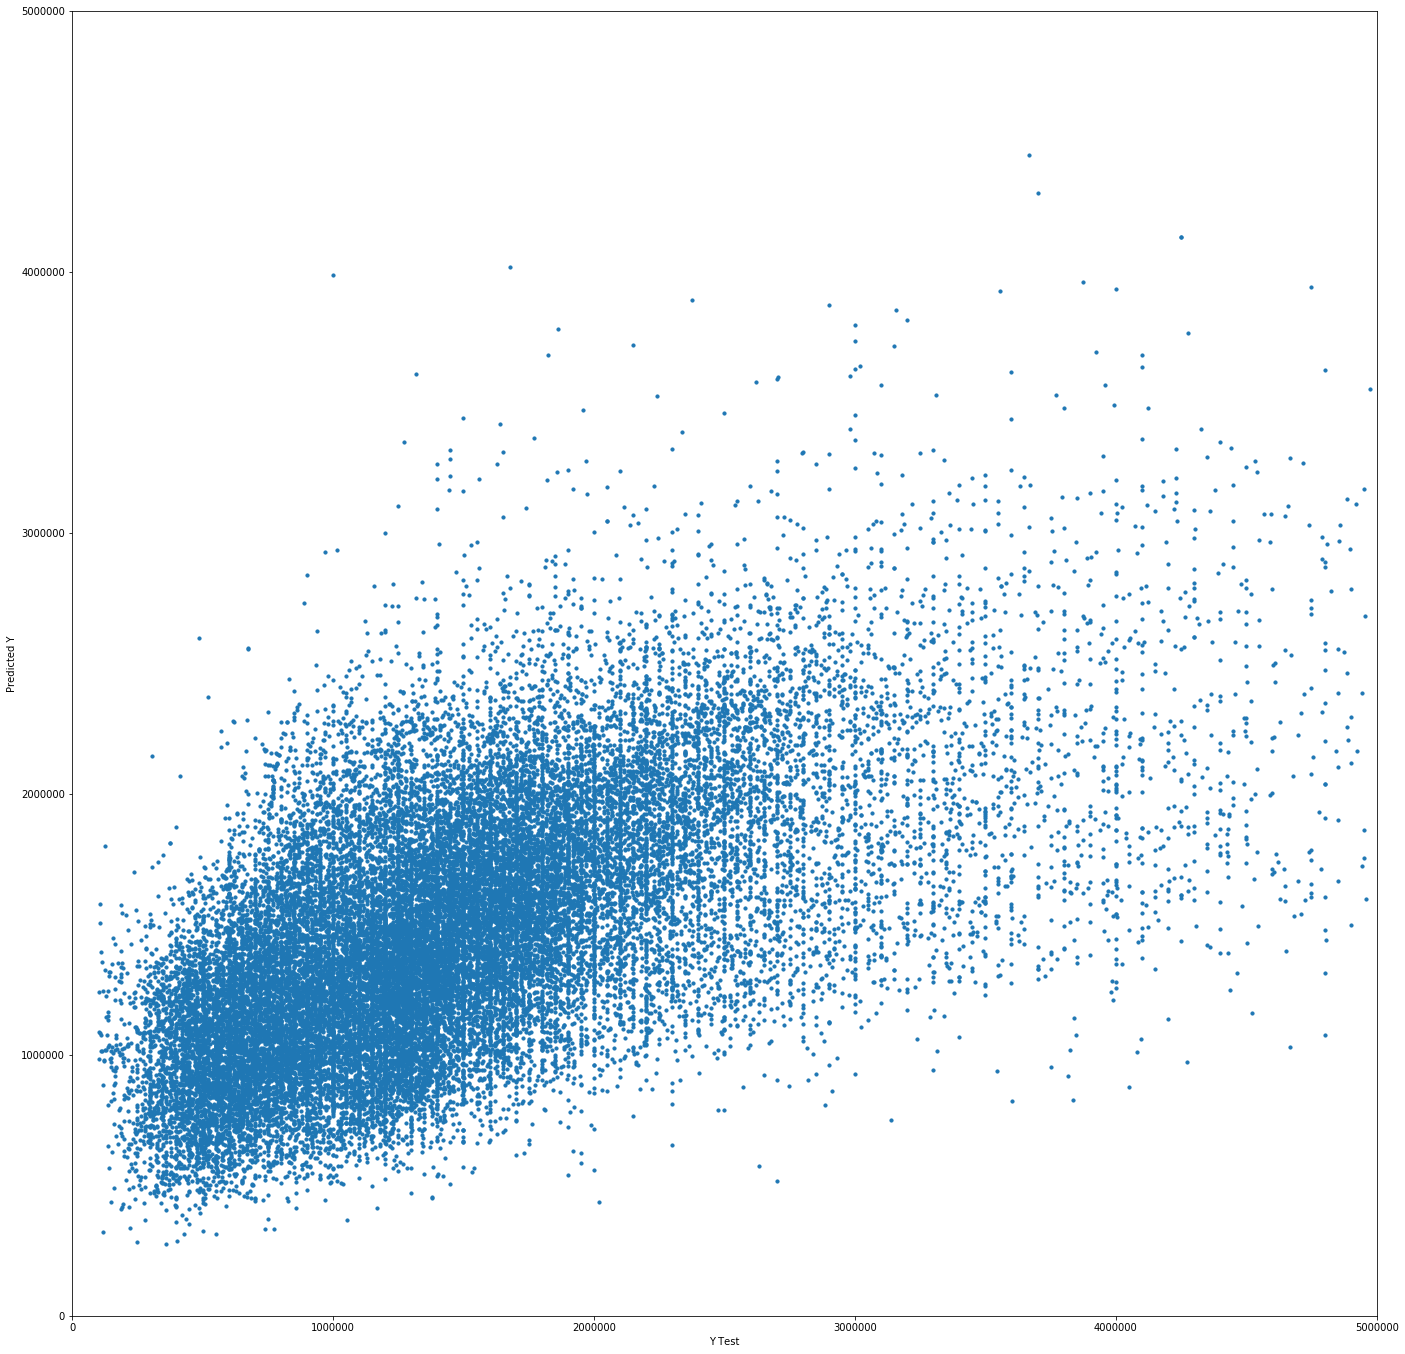

In [25]:
plt.rcParams['figure.figsize'] = (24,24)
plt.scatter(y_test, predictions, s=10)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
# set axes range
_min, _max = 0, max_price
plt.xlim(_min, _max)
plt.ylim(_min, _max)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

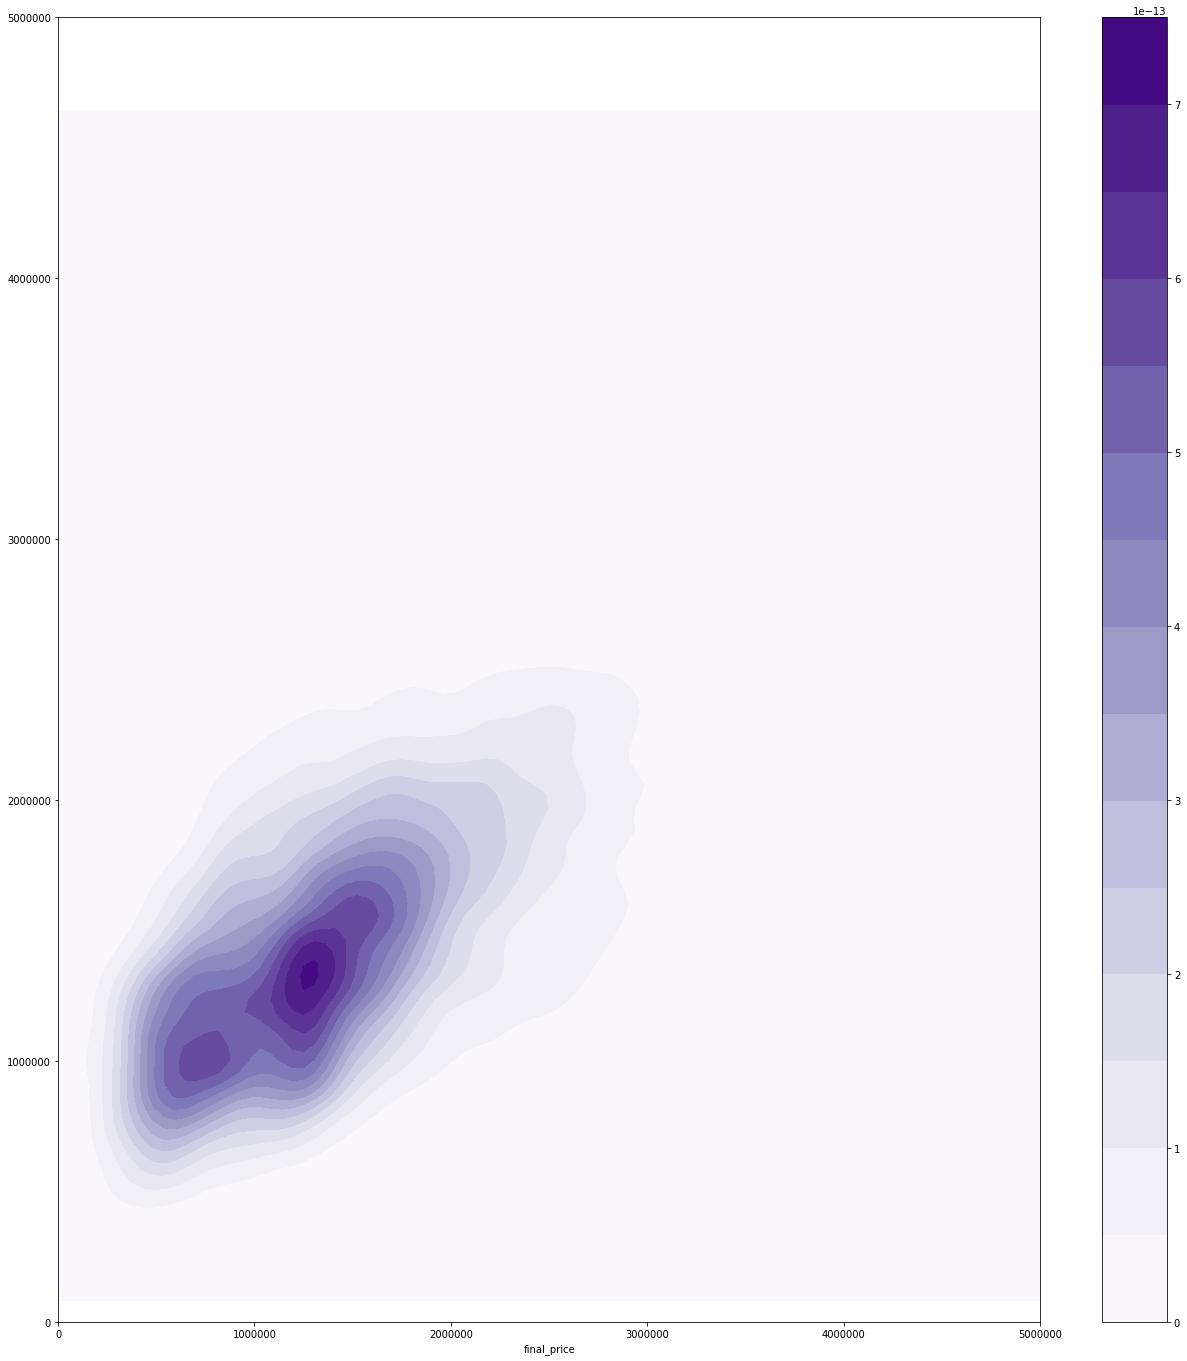

In [24]:
plt.figure(figsize=(22, 24))
g = sns.kdeplot(y_test, predictions, cmap="Purples", shade=True, n_levels=15, cbar=True)
g.set(ylim=(_min, _max), xlim=(_min, _max))
plt.show()


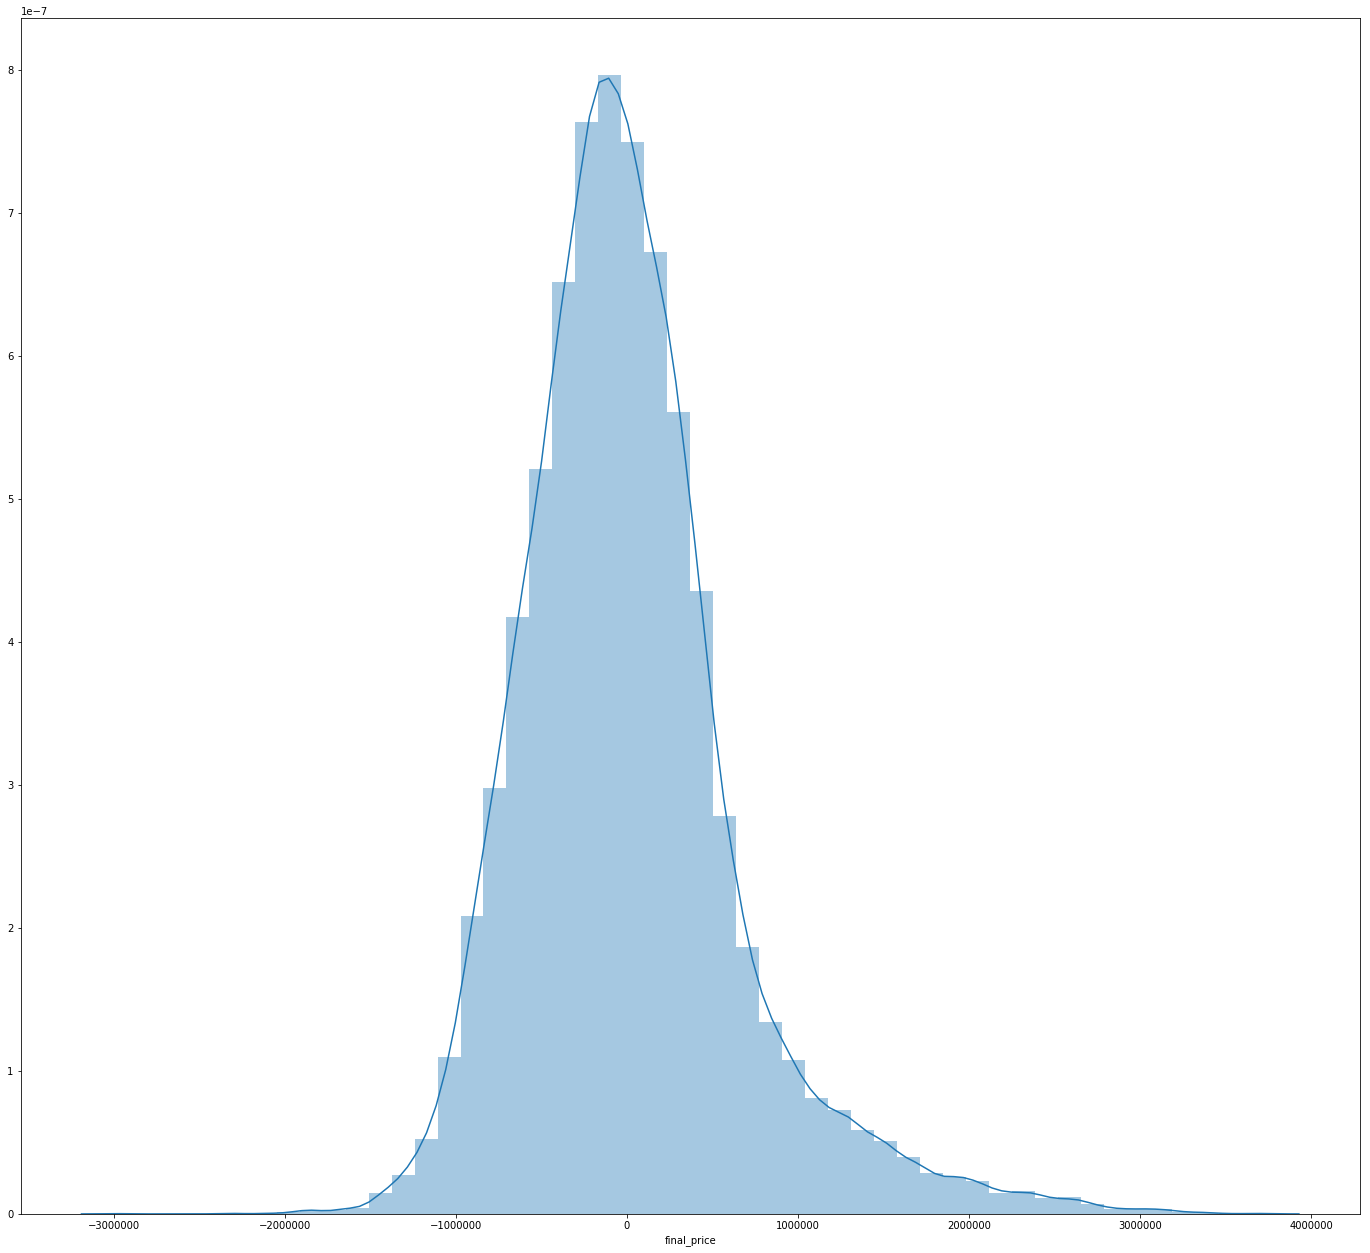

In [27]:
plt.figure(figsize=(24, 22))
sns.distplot((y_test-predictions), bins=50)
plt.show()

In [26]:
lm.score(X,y)

0.37644956954627345

In [28]:
import statsmodels.api as sm
X_constant = sm.add_constant(X)
model = sm.OLS(y, X_constant)
lin_reg = model.fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            final_price   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                 1.154e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:43:26   Log-Likelihood:            -2.5402e+06
No. Observations:              172080   AIC:                         5.080e+06
Df Residuals:                  172070   BIC:                         5.081e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.468e+05   8878.140     27.796      0.000    2.29e+05    2.64e+05
sale_day            95.9528      3.521     27.248      0.000      89.051     102.855
street_name        -23.4088      1.405    -16.662      0.000     -26.162     -20.655
street_number       51.2075      5.076     10.089      0.000      41.259      61.156
property_type     4.991e+04   2372.309     21.038      0.000    4.53e+04    5.46e+04
rooms_number       4.55e+04   1313.025     34.652      0.000    4.29e+04    4.81e+04
floor             3.162e+04    434.169     72.819      0.000    3.08e+04    3.25e+04
build_year_class -1.136e+05   2300.594    -49.375      0.000   -1.18e+05   -1.09e+05
building_mr       7811.0666     76.842    101.651      0.000    7660.458    7961.676
city              3242.7787     27.624    117.392      0.000    3188.637    3296.920
==============================================================================
Omnibus:                    32073.981   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78285.560
Skew:                           1.044   Prob(JB):                         0.00
Kurtosis:                       5.560   Cond. No.                     1.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
from sklearn.metrics import mean_squared_error
# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, predictions))
print("Mean squared error sqrt:", sqrt(mean_squared_error(y_test, predictions)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, predictions))

Coefficients: 
 [ 9.55763396e+01 -2.39707881e+01  5.12563324e+01  4.97907126e+04
  4.60154871e+04  3.17785195e+04 -1.13210947e+05  7.79869739e+03
  3.24159795e+03]
Mean squared error: 392168341023.39
Mean squared error sqrt: 626233.4556883639
Variance score: 0.37


In [30]:
# define 2 groups of data
p = 2750000
threshold = 500000
df1 = df[df['final_price'] <= p + threshold]
df2 = df[df['final_price'] >= p - threshold]
print(df1.shape)
print(df2.shape)

(165936, 15)
(25221, 15)


In [31]:
X = df1[used_features]
y = df1['final_price']

In [32]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
# integer encode
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
# integer_encoded = df.apply(le.fit_transform)

# apply the values into the original data
for row in X[used_features]:
    X[row] = le.fit_transform(df1[row])


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [34]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
print(lm.intercept_)

448259.04599040514


In [36]:
print(X.columns)
print(lm.coef_)

Index(['sale_day', 'street_name', 'street_number', 'property_type',
       'rooms_number', 'floor', 'build_year_class', 'building_mr', 'city'],
      dtype='object')
[ 8.98037420e+01 -2.20755922e+01  4.81280584e+01  3.30044467e+04
  5.54473811e+04  2.36215608e+04 -1.24556726e+05  5.76307278e+03
  2.37884475e+03]


In [37]:
predictions = lm.predict(X_test)

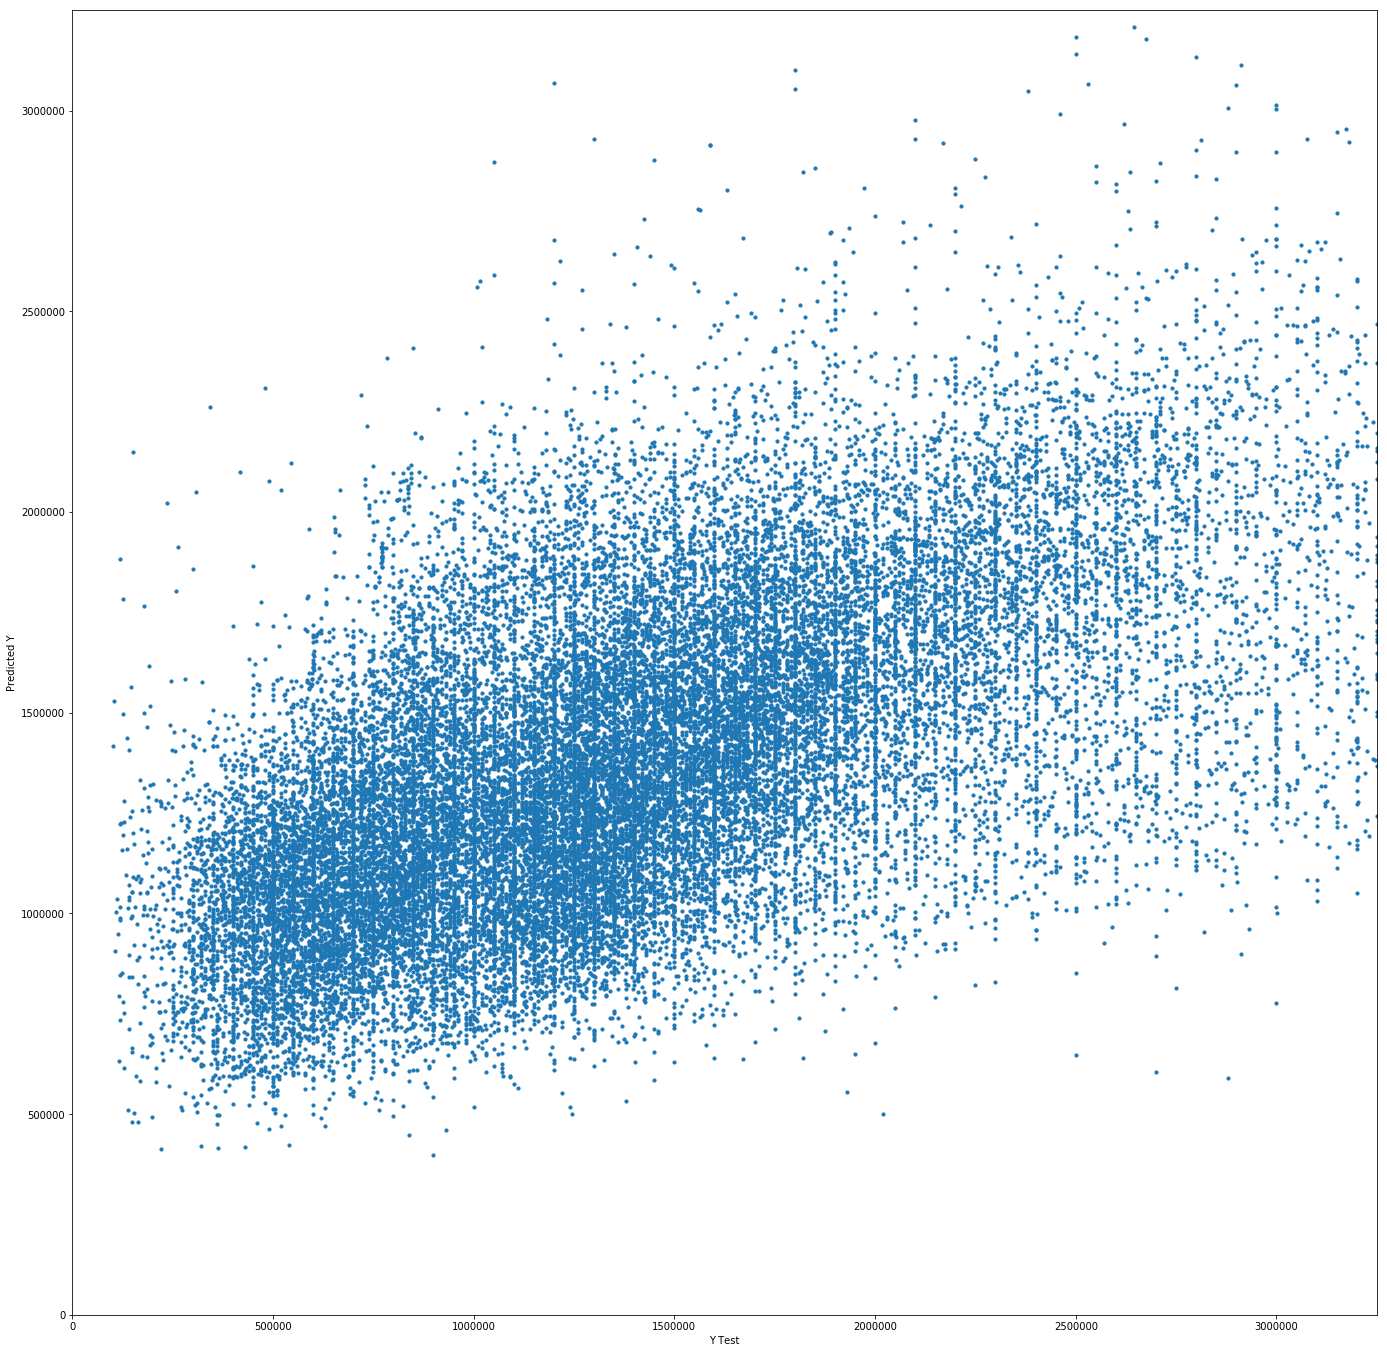

In [38]:
plt.scatter(y_test, predictions, s=10)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
# set axes range
_min, _max = 0, p + threshold
plt.xlim(_min, _max)
plt.ylim(_min, _max)
plt.rcParams['figure.figsize'] = (24,24)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, predictions))
print("Mean squared error sqrt:", sqrt(mean_squared_error(y_test, predictions)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, predictions))

Coefficients: 
 [ 8.98037420e+01 -2.20755922e+01  4.81280584e+01  3.30044467e+04
  5.54473811e+04  2.36215608e+04 -1.24556726e+05  5.76307278e+03
  2.37884475e+03]
Mean squared error: 266769905294.35
Mean squared error sqrt: 516497.73019283084
Variance score: 0.36


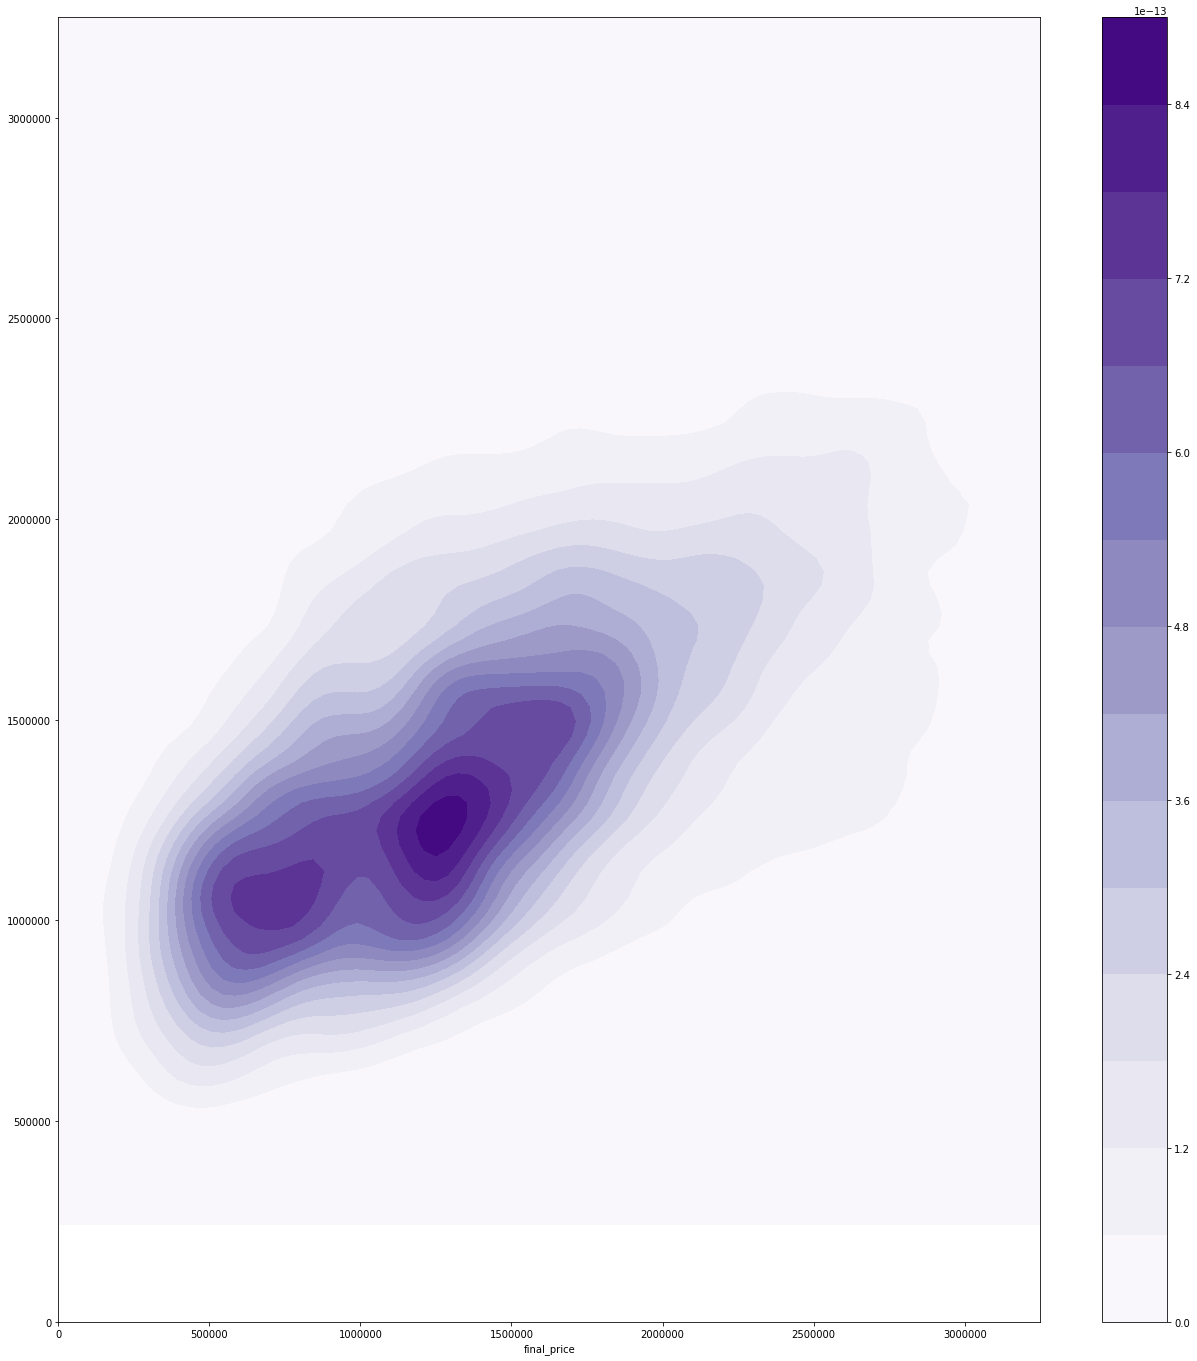

In [40]:
plt.figure(figsize=(22, 24))
g = sns.kdeplot(y_test, predictions, cmap="Purples", shade=True, n_levels=15, cbar=True)
g.set(ylim=(_min, _max), xlim=(_min, _max))
plt.show()

In [41]:
X = df2[used_features]
y = df2['final_price']

In [42]:
# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
# integer encode
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
# integer_encoded = df.apply(le.fit_transform)

# apply the values into the original data
for row in X[used_features]:
    X[row] = le.fit_transform(df2[row])


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [44]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [45]:
print(lm.intercept_)

2174213.153713203


In [46]:
print(X.columns)
print(lm.coef_)

Index(['sale_day', 'street_name', 'street_number', 'property_type',
       'rooms_number', 'floor', 'build_year_class', 'building_mr', 'city'],
      dtype='object')
[ 4.14359169e+01  1.44688121e+01  8.68501921e+01  1.44089109e+04
 -2.18200029e+04  1.33757150e+04  5.93120728e+04  3.97710677e+03
  3.48107431e+03]


In [47]:
predictions = lm.predict(X_test)

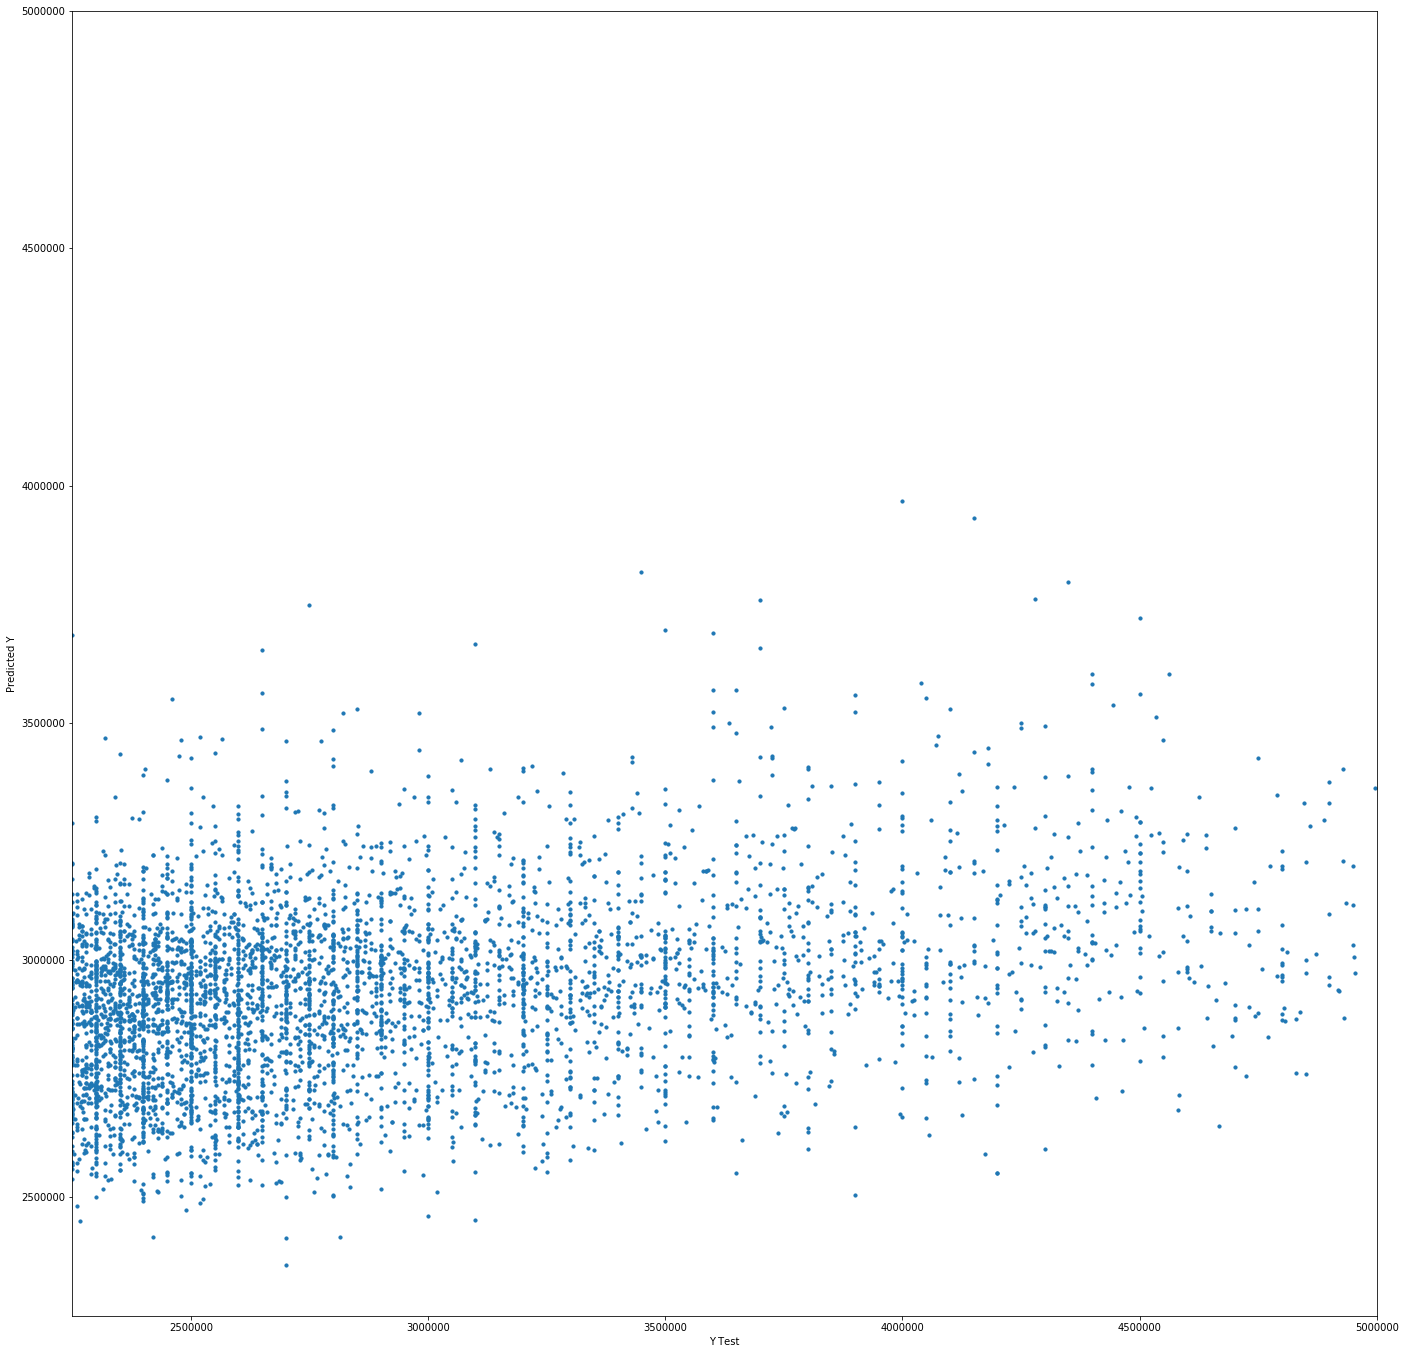

In [48]:
plt.scatter(y_test, predictions, s=10)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
# set axes range
_min, _max = p - threshold, max_price
plt.xlim(_min, _max)
plt.ylim(_min, _max)
plt.rcParams['figure.figsize'] = (24,24)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

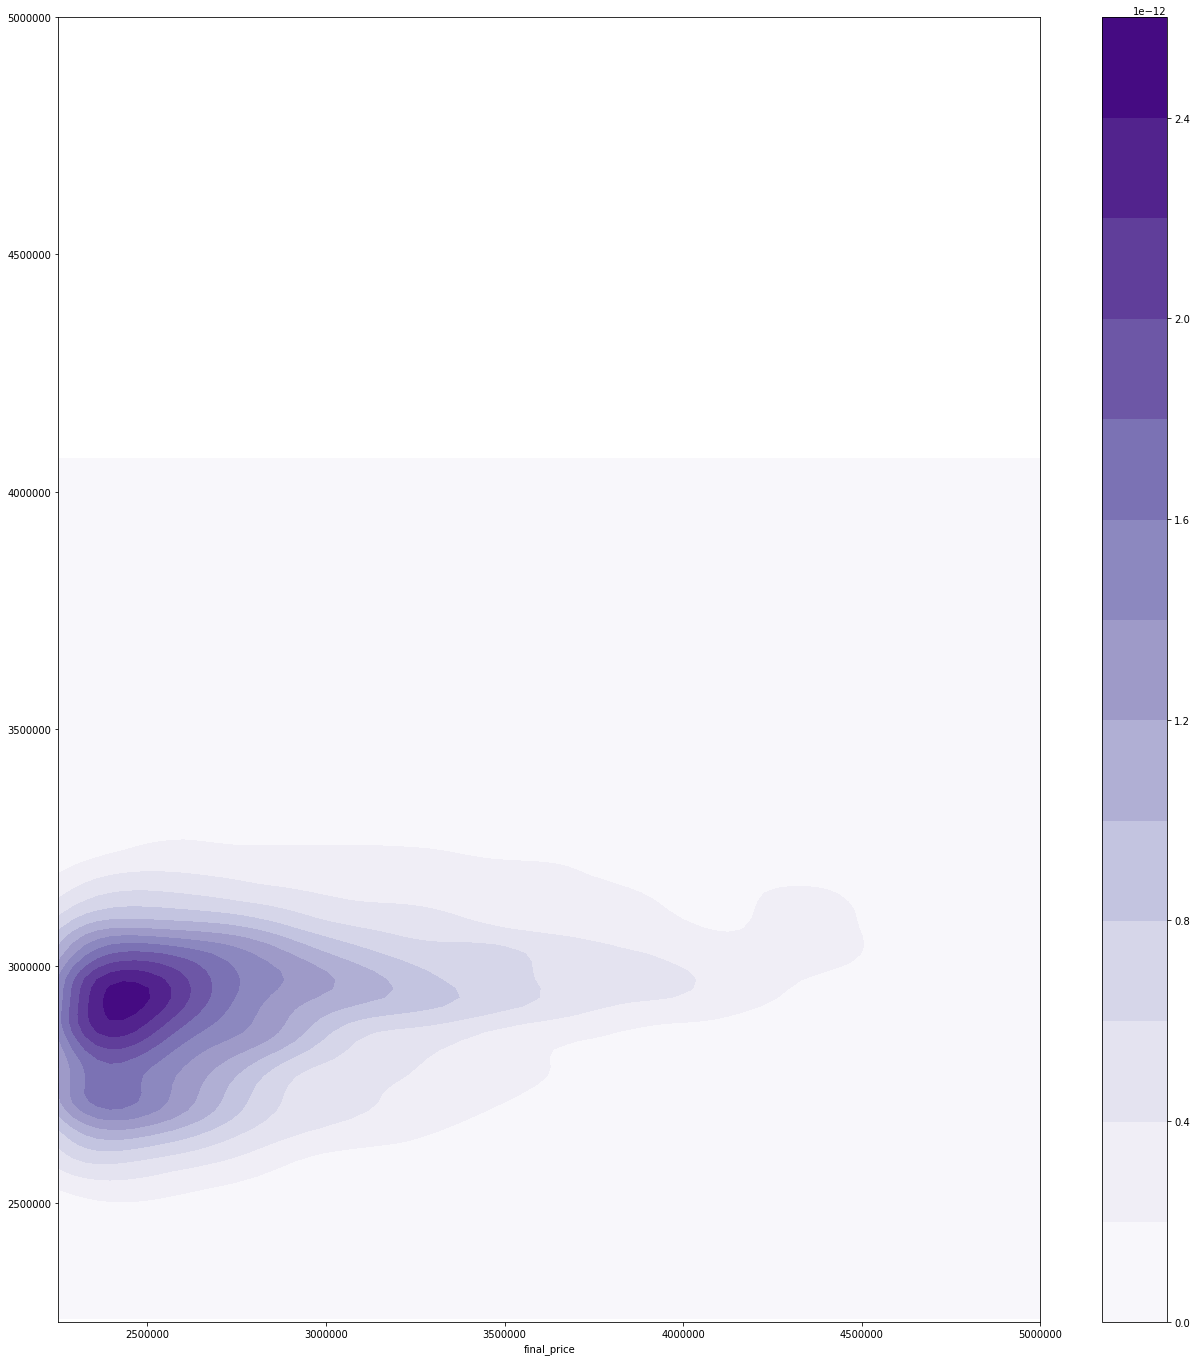

In [49]:
plt.figure(figsize=(22, 24))
g = sns.kdeplot(y_test, predictions, cmap="Purples", shade=True, n_levels=15, cbar=True)
g.set(ylim=(_min, _max), xlim=(_min, _max))
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, predictions))
print("Mean squared error sqrt:", sqrt(mean_squared_error(y_test, predictions)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, predictions))

Coefficients: 
 [ 4.14359169e+01  1.44688121e+01  8.68501921e+01  1.44089109e+04
 -2.18200029e+04  1.33757150e+04  5.93120728e+04  3.97710677e+03
  3.48107431e+03]
Mean squared error: 341848424129.82
Mean squared error sqrt: 584678.0516915455
Variance score: 0.10
